# Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/TRAINING

In [2]:
%%capture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
!pip install pypdf
from pypdf import PdfReader
from sklearn.metrics.pairwise import cosine_similarity
from helpers import *
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np


In [3]:
def get_similarity_userskills(inputtext, topn = 10):
  if isinstance(inputtext,str):
    inputtext = [inputtext]
  path = "../00_data/TF-IDF_Vectorizer"
  vectorizer = load_pickle(path+"1_vectorizer.pkl")
  tfidf_matrix = load_pickle(path+"1_tfidf_matrix.pkl")
  jobtitles = load_pickle(path+"1_jobnames.pkl")
  inputtfidf = vectorizer.transform(inputtext)
  cosine_sim = cosine_similarity(tfidf_matrix,inputtfidf)
  cossim_df = pd.DataFrame(cosine_sim, index = jobtitles, columns=["Similarity"]).sort_values(by="Similarity",ascending=False)
  return cossim_df

In [4]:
def get_similarity_userskills_input(inputtext,vectorizer,tfidf_matrix):
  if isinstance(inputtext,str):
    inputtext = [inputtext]

  jobtitles = load_pickle(r"../00_data/TF-IDF_Vectorizer/1_jobnames.pkl")
  inputtfidf = vectorizer.transform(inputtext)
  cosine_sim = cosine_similarity(inputtfidf,tfidf_matrix)

  return cosine_sim

In [5]:
def evaluate(cosine_sim):
  ranks = []
  simdf = pd.DataFrame(cosine_sim, columns=job_ids, index=testad_ids)
  for i in (range(len(simdf))):
    id = simdf.iloc[i].name
    series = simdf.iloc[i].sort_values(ascending=False).reset_index()
    rank = series[series["index"]==id].index.item()+1
    if rank > 100:
      ranks.append(0)
      continue
    else:
      ranks.append(1/rank)
  return np.mean(ranks)

In [6]:
def load_cvs():
    cvs = []
    for i in range(1,6):
        cv = ""
        reader = PdfReader(f"../00_data/CVs/CV_{i}.pdf")

        pages = reader.pages
        for i in range(len(pages)):
            page = reader.pages[i].extract_text().strip()
            cv +=page
        cvs.append(cv)
    return cvs

In [7]:
german_stop_words = stopwords.words('german')

# Data

In [8]:
jobs = pd.DataFrame(load_json(r"../00_data/ESCO/ESCO_JOBS_ALL.json"))
jobs.columns

Index(['jobid_esco', 'jobtitle', 'skills', 'additional_skills',
       'jobdescription', 'synonyms', 'jobcategory', 'jobcategoryid', 'uri',
       'full_skills'],
      dtype='object')

In [9]:
jobtitle = list(jobs["jobtitle"])
job_ids = list(jobs["jobid_esco"])

## Synonyms

In [10]:
def insert_jobtitle_to_synonyms(ad):
  if ad["synonyms"] == None:
    return ad["jobtitle"].split("/")
  else:
    return ad["synonyms"]
jobs["synonyms_altered"] = jobs.apply(insert_jobtitle_to_synonyms,axis=1)

In [11]:
unique_synonyms = list(set(flatten_list([x for x in jobs["synonyms_altered"] if x != None])))
len(unique_synonyms)
synonym_l_of_l = [" ".join(x) for x in jobs["synonyms_altered"]]

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=german_stop_words)
vectorizer = vectorizer.fit(unique_synonyms)
tfidf_matrix = vectorizer.transform(synonym_l_of_l)
features = vectorizer.get_feature_names_out()

## Skills

In [13]:
skilllist = set(flatten_list(jobs["full_skills"]))
len(skilllist)

12572

In [14]:
fullskills_jobs = [" ".join(skillset) for skillset in jobs["full_skills"]]

# print(len(fullskills_jobs))
# print(jobtitle[0])
# fullskills_jobs[0]

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=german_stop_words)
vectorizer = vectorizer.fit(skilllist)

tfidf_matrix = vectorizer.transform(fullskills_jobs)
features = vectorizer.get_feature_names_out()
tfidf_matrix

<2937x30870 sparse matrix of type '<class 'numpy.float64'>'
	with 399572 stored elements in Compressed Sparse Row format>

## Combination


In [16]:
# info_unique_concat = list(unique_synonyms) + list(skilllist)
# total_l_of_l = []

# for syns, skills in zip(jobs["synonyms_altered"],jobs["full_skills"]):
#   total_l_of_l.append(" ".join(syns+skills))

In [17]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=german_stop_words)
# vectorizer = vectorizer.fit(info_unique_concat)
# tfidf_matrix = vectorizer.transform(total_l_of_l)
# features = vectorizer.get_feature_names_out()
# tfidf_matrix

## Descriptions

In [18]:
# unique_desc = (jobs["jobdescription"])
# vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=german_stop_words)
# tfidf_matrix = vectorizer.fit_transform(unique_desc)
# features = vectorizer.get_feature_names_out()

# Application

In [19]:
path = "../00_data/TF-IDF_Vectorizer/"

In [20]:
# idf_list = []
# for idf, word in zip(vectorizer.idf_, vectorizer.get_feature_names_out()):
#   idf_list.append({"idf":idf,"word":word})
# pd.DataFrame(idf_list).sort_values("idf")

In [36]:
write_pickle(f"{path}1_vectorizer.pkl", vectorizer)
write_pickle(f"{path}1_tfidf_matrix.pkl", tfidf_matrix)
write_pickle(f"{path}1_jobnames.pkl", jobtitle)
write_pickle(f"{path}1_escoids.pkl", job_ids)

Pickle saved.
Pickle saved.
Pickle saved.
Pickle saved.


In [22]:
testads = pd.DataFrame(load_json(r"../00_data/EURES/eures_testads_final_short.json"))

In [23]:
testad_texts = list(testads["short_texts"])
testad_ids = list(testads["esco_id"])

# Setup Vec & Matrix

In [24]:
evaluation = []
for vec in [TfidfVectorizer]:#, CountVectorizer]:
  for ngram in [(1,1),(1,2),(1,3)]:
    for stopword_removal in [True, False]:
      if stopword_removal == True:
        vectorizer = vec(ngram_range=ngram, stop_words=german_stop_words)
      else:
        vectorizer = vec(ngram_range=ngram)
      vectorizer = vectorizer.fit(skilllist)
      tfidf_matrix = vectorizer.transform(fullskills_jobs)
      #tfidf_matrix = vectorizer.fit_transform(unique_desc)
      cosine_sim = get_similarity_userskills_input(testad_texts,vectorizer,tfidf_matrix)
      max_value = (max(map(max, cosine_sim)))
      MRR = evaluate(cosine_sim)
      evaluation.append({"vectorizer":str(vec).split(".")[-1][:-2],"n-gram range":ngram,
                         "stopword_removal":stopword_removal,"MRR@100":MRR,"max_similarity":max_value})
display(pd.DataFrame(evaluation))

,vectorizer,n-gram range,stopword_removal,MRR@100,max_similarity
0,TfidfVectorizer,"(1, 1)",True,0.053935,0.451092
1,TfidfVectorizer,"(1, 1)",False,0.012076,0.630480
2,TfidfVectorizer,"(1, 2)",True,0.055280,0.394645
3,TfidfVectorizer,"(1, 2)",False,0.013469,0.513845
4,TfidfVectorizer,"(1, 3)",True,0.055509,0.376770
5,TfidfVectorizer,"(1, 3)",False,0.013728,0.472793


C:\Users\lw\AppData\Local\Temp\ipykernel_12340\1613360346.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = df[df["vectorizer"]=="TfidfVectorizer"].pivot("n-gram range","stopword_removal",values="MRR@100").plot(kind="bar", figsize=(12, 5),ylabel="MRR@100",title="Comparison of TFIDF Settings")


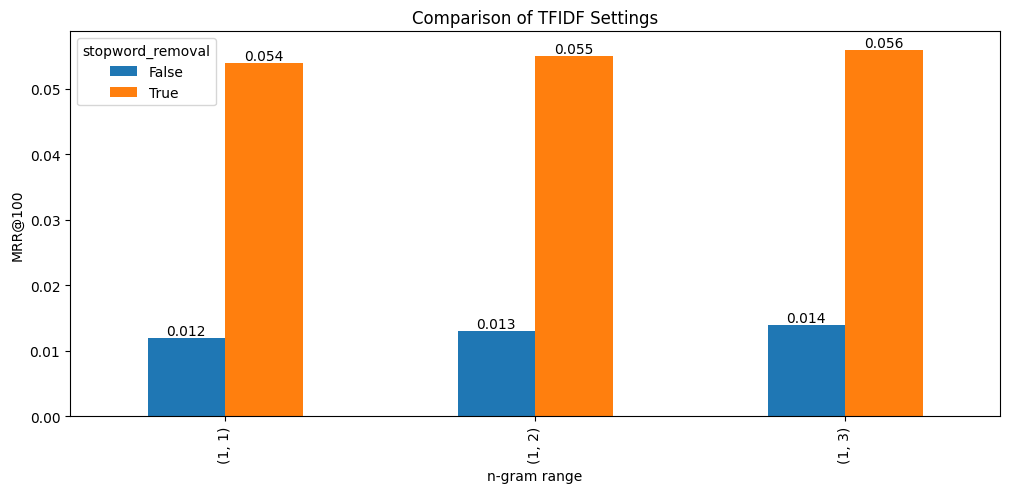

In [25]:
df = pd.DataFrame(evaluation)
df["MRR@100"] = df["MRR@100"].round(3)
ax = df[df["vectorizer"]=="TfidfVectorizer"].pivot("n-gram range","stopword_removal",values="MRR@100").plot(kind="bar", figsize=(12, 5),ylabel="MRR@100",title="Comparison of TFIDF Settings")
for container in ax.containers:
    ax.bar_label(container)

In [26]:
cvs = load_cvs()

In [27]:
def get_similarity_userskills(inputtext,vectorizer,tfidf_matrix, topn = 10):
  if isinstance(inputtext,str):
    inputtext = [inputtext]
  jobtitles = load_pickle(r"../00_data/TF-IDF_Vectorizer/1_jobnames.pkl")
  inputtfidf = vectorizer.transform(inputtext)
  cosine_sim = cosine_similarity(tfidf_matrix,inputtfidf)
  cossim_df = pd.DataFrame(cosine_sim, index = jobtitles, columns=["Similarity"]).sort_values(by="Similarity",ascending=False)
  return cossim_df

In [28]:
text = cvs[1]

In [29]:
inputtfidf = vectorizer.transform([text])
features = vectorizer.get_feature_names_out()
df = pd.DataFrame(inputtfidf.toarray(),index =["input"], columns = features).T.sort_values(by="input",ascending=False)
df[df["input"]!=0]

,input
ausbildung,0.452939
und,0.277281
kg,0.166647
engagement,0.166647
klasse,0.166647
sprachkenntnisse,0.166647
edv kenntnisse,0.166647
microsoft office,0.166647
moderation,0.166647
office,0.166647


In [30]:
get_similarity_userskills(text, vectorizer,tfidf_matrix).iloc[:20]

,Similarity
Großhändler/Großhändlerin,0.171334
Import-/Exportmanager/Import-/Exportmanagerin,0.163769
Import-/Exportsachbearbeiter/Import-/Exportsachbearbeiterin,0.157048
Vertriebsleiter/Vertriebsleiterin,0.149154
Fachverkäufer/Fachverkäuferin,0.122156
Facharzt/Fachärztin,0.121207
Transportkoordinator Seefracht/Transportkoordinatorin Seefracht,0.120789
Vermietassistent Bau- und Arbeitsmaschinen/Vermietassistentin Bau- und Arbeitsmaschinen,0.118086
Führungskraft für die Zucht aquatischer Organismen,0.115794
Schokoladenformmaschinenbediener/Schokoladenformmaschinenbedienerin,0.112298


In [31]:
def get_tfidf_features_job(job, tfidf_matrix):
    index = jobtitle.index(job)
    feature_dict = {}
    for v, feature in zip(tfidf_matrix[index].toarray()[0], features):
        if v != 0:
            feature_dict[feature] = v
    return (feature_dict)

In [32]:
def get_tfidf_features(text):
    inputtfidf = vectorizer.transform([(text)])
    features = vectorizer.get_feature_names_out()
    input_dict = {}
    for v, feature in zip(inputtfidf.toarray()[0], features):
            if v != 0:
                input_dict[feature] = v
    return (input_dict)

In [33]:
def compare_tfidf(text, job, tfidf_matrix):
    input_tfidf = get_tfidf_features(text)
    #print(input_tfidf)
    jobfeatures = get_tfidf_features_job(job, tfidf_matrix)
    #print(jobfeatures)
    output_dict = {}
    for k in jobfeatures:
        if k in input_tfidf:
            output_dict[k] = input_tfidf[k]
    return output_dict

In [34]:
compare_tfidf(text,"Spieleentwickler/Spieleentwicklerin",tfidf_matrix)

{'für': 0.06041932887502209,
 'kenntnisse': 0.14522641598469282,
 'spielen': 0.13109125082543943}